# Pypose
In diesem Notebook wird Pypose genutzt, um eine Position aus IMU-Daten zu berechnen

In [2]:
import torch
import numpy as np
import pypose as pp
import torch.utils.data as Data
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.collections import PatchCollection

In [17]:
class My_IMU(Data.Dataset):
    def __init__(self, root, duration=2, step_size=2):
        super().__init__()
        self.duration = duration
        
        self.data = np.load(root)
        self.seq_len = len(self.data) - 1

        self.dt = torch.tensor([0.001 for i in range(self.seq_len)])

        self.gyro = torch.tensor(self.data[:,3:6]).float()

        self.acc = torch.tensor(self.data[:,:3]).float()

        start_frame = 0
        end_frame = self.seq_len


        self.index_map = [i for i in range(
            0, end_frame - start_frame - self.duration, step_size)]

    def __len__(self):
        return len(self.index_map)

    def __getitem__(self, i):
        frame_id = self.index_map[i]
        end_frame_id = frame_id + self.duration
        return {
            'dt': self.dt[frame_id: end_frame_id],
            'acc': self.acc[frame_id: end_frame_id],
            'gyro': self.gyro[frame_id: end_frame_id],
            'gyro': self.gyro[frame_id: end_frame_id],
            'init_pos': torch.tensor([0,0,0])
        }

    def get_init_value(self):
        return {'pos': torch.tensor([[0.,0.,0.]]),
                'rot': pp.LieTensor([[0.1,0.1,-1,0.1]], ltype=pp.SO3_type),
                #'rot': samplerot,
                'vel': torch.tensor([0])}


In [9]:
def imu_collate(data):
    acc = torch.stack([d['acc'] for d in data])
    gyro = torch.stack([d['gyro'] for d in data])
    dt = torch.stack([d['dt'] for d in data]).unsqueeze(-1)

    return {
        'dt': dt,
        'acc': acc,
        'gyro': gyro,
    }

In [10]:
def move_to(obj, device):
    if torch.is_tensor(obj):
        return obj.to(device)
    elif isinstance(obj, dict):
        res = {}
        for k, v in obj.items():
            res[k] = move_to(v, device)
        return res
    elif isinstance(obj, list):
        res = []
        for v in obj:
            res.append(move_to(v, device))
        return res
    else:
        raise TypeError("Invalid type for move_to", obj)

In [11]:
def plot_gaussian(ax, means, covs, color=None, sigma=3):
    ellipses = []
    for i in range(len(means)):
        eigvals, eigvecs = np.linalg.eig(covs[i])
        axis = np.sqrt(eigvals) * sigma
        slope = eigvecs[1][0] / eigvecs[1][1]
        angle = 180.0 * np.arctan(slope) / np.pi
        ellipses.append(Ellipse(means[i, 0:2], axis[0], axis[1], angle=angle))
    ax.add_collection(PatchCollection(ellipses, edgecolors=color, linewidth=1))

Saved to ./data/rechtskurve.npy_poseplot.png


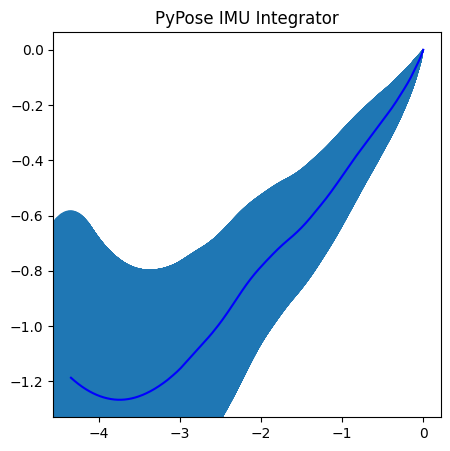

In [19]:
device = 'cpu' # 'cuda'
data_path = './data/rechtskurve.npy'
dataset = My_IMU(data_path)


loader = Data.DataLoader(dataset=dataset,
                            batch_size=1,
                            collate_fn=imu_collate,
                            shuffle=False)

# step 2: Get the initial position, rotation and velocity, all 0 here
init = dataset.get_init_value()

integrator = pp.module.IMUPreintegrator(init['pos'],
                                        init['rot'],
                                        init['vel'],
                                        reset=False).to(device)

# step 3: Perform integration
poses = [init['pos']]
covs = [torch.zeros(9, 9)]

for idx, data in enumerate(loader):
    data = move_to(data, device)
    state = integrator(dt=data['dt'],
                        gyro=data['gyro'],
                        acc=data['acc'],
                        rot=torch.tensor([0,0,0]))
    poses.append(state['pos'][..., -1, :].cpu())
    covs.append(state['cov'][..., -1, :, :].cpu())

poses = torch.cat(poses).numpy()
covs = torch.stack(covs, dim=0).numpy()

# step 4: Visualization
plt.figure(figsize=(5, 5))

ax = plt.axes()
ax.plot(poses[:, 0], poses[:, 1], 'b')
plot_gaussian(ax, poses[:, 0:2], covs[:, 6:8, 6:8])
plt.title("PyPose IMU Integrator")
figure = data_path+ '_poseplot.png'
plt.savefig(figure)
print("Saved to", figure)

Das Ergebnis ist zwar nicht up to scale, aber ich sehe zum ersten Mal, dass die Kurve aus reinen IMU-Daten relativ genau abgebildet wird.

Das Ergebnis ist wirklich deutlich besser als alles, was ich bisher probiert habe.